In [76]:
import warnings
warnings.filterwarnings("ignore")

In [110]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import statsmodels.api as sm
from arch.unitroot import ADF
import yfinance as yf

trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)
threshold = 1.96

def adfTest(series):
    adfT = ADF(series)
    if adfT.pvalue > 0.05:
        return False, adfT.pvalue
    return True, adfT.pvalue

def visualize(data, symbols):
    plt.figure(figsize=(15, 7))
    for syl in symbols:
        data[syl].plot(label=syl)
    plt.legend()
    plt.ylabel('Adjusted YTM')
    plt.show()
    print("Successfully Plot YTM")

def spread(X, Y):
    spread = Y - X
    if not adfTest(spread)[0]:
        print("Spread is not stationary. P value of ADF test is", adfTest(spread)[1])
    else:
        print('''
            Spread is stationary
            P value of ADF test: %f
            ''' % (adfTest(spread)[1]))

def cointegration(X, Y):
    results = sm.OLS(Y, sm.add_constant(X)).fit()
    resid = results.resid
    if not adfTest(resid)[0]:
        print("X and Y are not cointegrated. P value of ADF test is", adfTest(resid)[1])
        return None
    else:
        print('''
        X and Y are cointegrated
        P value of ADF test: %f
        Intercept: %f
        Beta: %f
        ''' % (adfTest(resid)[1], results.params[0], results.params[1]))
        return results.params[0], results.params[1]

def kalman_filter(data, symbols, trans_cov):
    obs_mat = sm.add_constant(data[symbols[0]].values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=np.ones(2),
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=0.5,
                      transition_covariance=trans_cov)
    state_means, state_covs = kf.filter(data[symbols[1]].values)
    slope=state_means[:, 0]
    intercept=state_means[:, 1]
    plt.figure(figsize =(15,7))
    plt.plot(data[symbols[1]].index, slope, c='b')
    plt.ylabel('slope')
    plt.title('kf updating slope')
    
    plt.figure(figsize =(15,7))
    plt.plot(data[symbols[1]].index,intercept,c='r')
    plt.ylabel('intercept')
    plt.title('kf updating intercept')
    plt.show()

    kl_spread = data[symbols[1]] - data[symbols[0]] * state_means[:, 0] - state_means[:, 1]
    return kl_spread

def set_signal(data, threshold, symbols):
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))
    df = pd.DataFrame()
    count = 0
    titles = ["Fixed Beta", "Kalman Filter"]

    for sym in symbols:
        mean, lower, upper, buy, sell = "mean_"+sym, "lower_"+sym, "upper_"+sym, "buy_"+sym, "sell_"+sym

        df['spread'] = data[sym]
        df[mean] = df['spread'].mean()
        df[upper] = df[mean] + threshold * df['spread'].std()
        df[lower] = df[mean] - threshold * df['spread'].std()

        df[buy] = df['spread'][((df['spread'] < df[lower]) & (df['spread'].shift(1) >= df[lower]))]
        df[sell] = df['spread'][((df['spread'] > df[upper]) & (df['spread'].shift(1) <= df[upper]))]

        pic = ax[count]
        pic.plot(df['spread'], 'g')
        pic.plot(df[mean], '--r', label=mean)
        pic.plot(df[upper], '--b', label=upper)
        pic.plot(df[lower], '--b', label=lower)
        pic.plot(df[buy], 'm^', label=buy)
        pic.plot(df[sell], 'cv', label=sell)

        pic.set_title(titles[count])
        pic.set_xlabel('Time')
        pic.set_ylabel('YTM' + titles[count])
        pic.legend()

        count+=1

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    print("Success!")

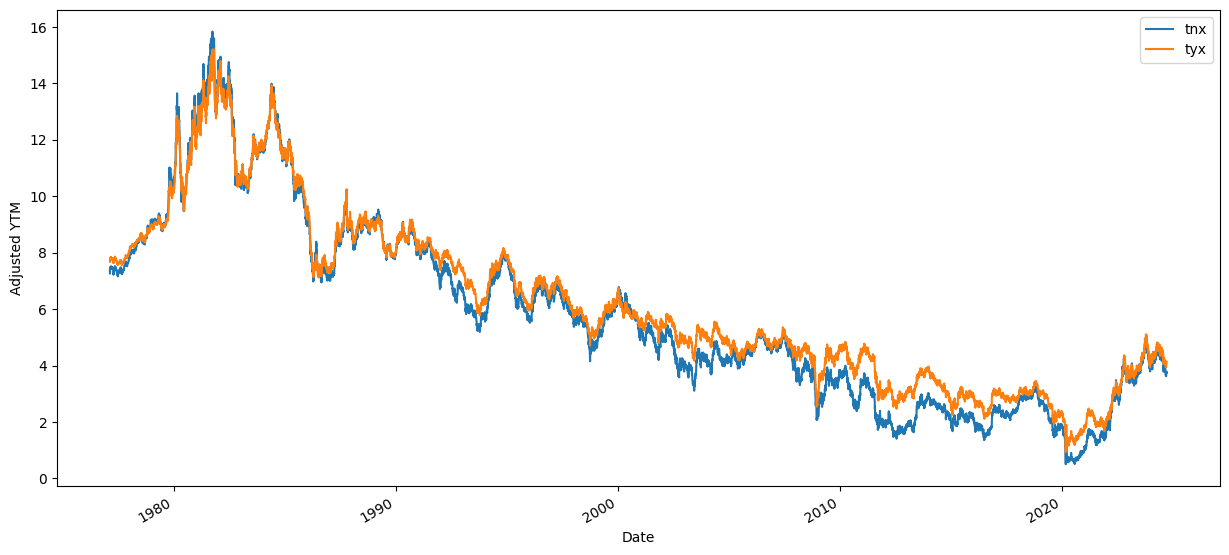

Successfully Plot YTM


In [92]:
tnx = yf.Ticker("^TNX")
tyx = yf.Ticker("^TYX")
hist = pd.DataFrame()

hist['tnx'] = pd.DataFrame(tnx.history(period="max")['Close'])
hist['tyx'] = pd.DataFrame(tyx.history(period="max")['Close'])
hist.dropna(axis = 0, inplace = True)

syms = ['tnx', 'tyx']
visualize(hist, syms)


In [93]:
spread(hist['tnx'], hist['tyx'])

Spread is not stationary. P value of ADF test is 0.05521127506095239


In [94]:
params = cointegration(hist['tnx'], hist['tyx'])
intercept = 0
beta = 0
if params is not None:
    intercept = params[0]
    beta = params[1]
res = pd.DataFrame()
coin_spread = hist['tyx'] - intercept - beta*hist['tnx']


        X and Y are cointegrated
        P value of ADF test: 0.006806
        Intercept: 0.899363
        Beta: 0.909902
        


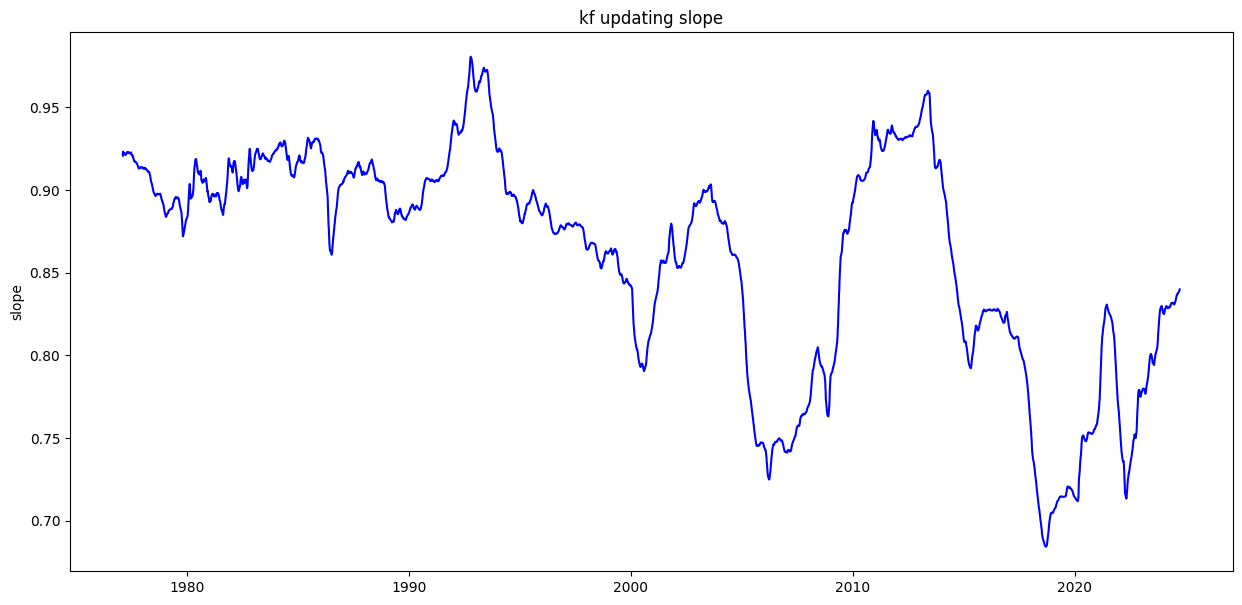

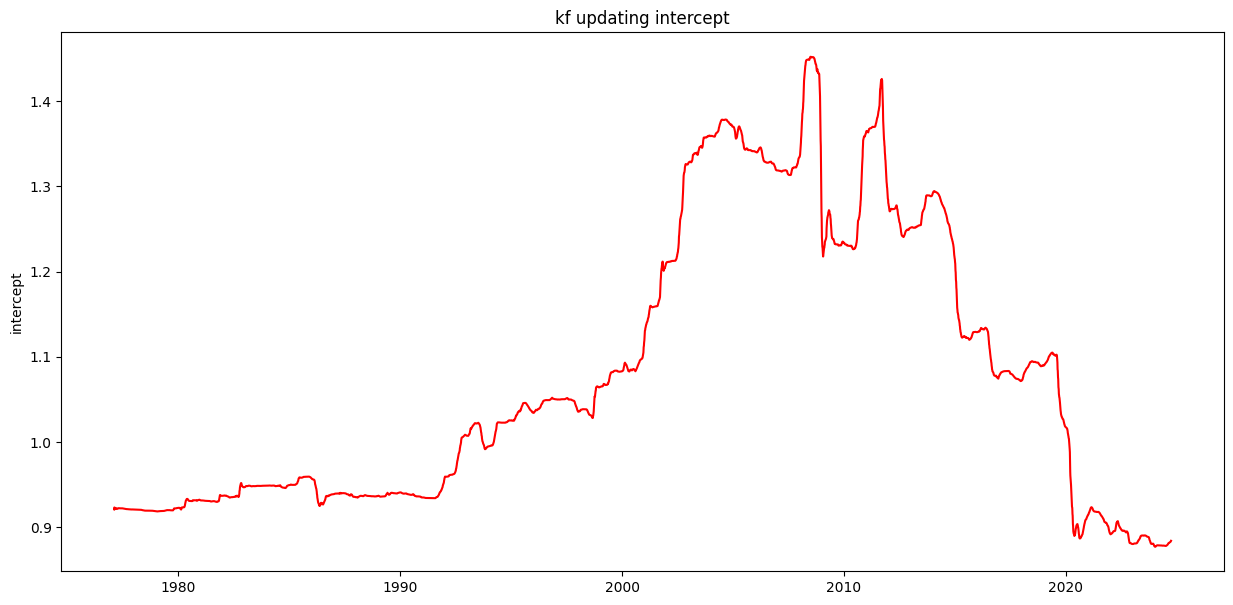

In [98]:
kf_spread = kalman_filter(hist, syms, trans_cov)

In [100]:
result = adfTest(kf_spread)
print(result)

(True, 1.9222022696695635e-19)


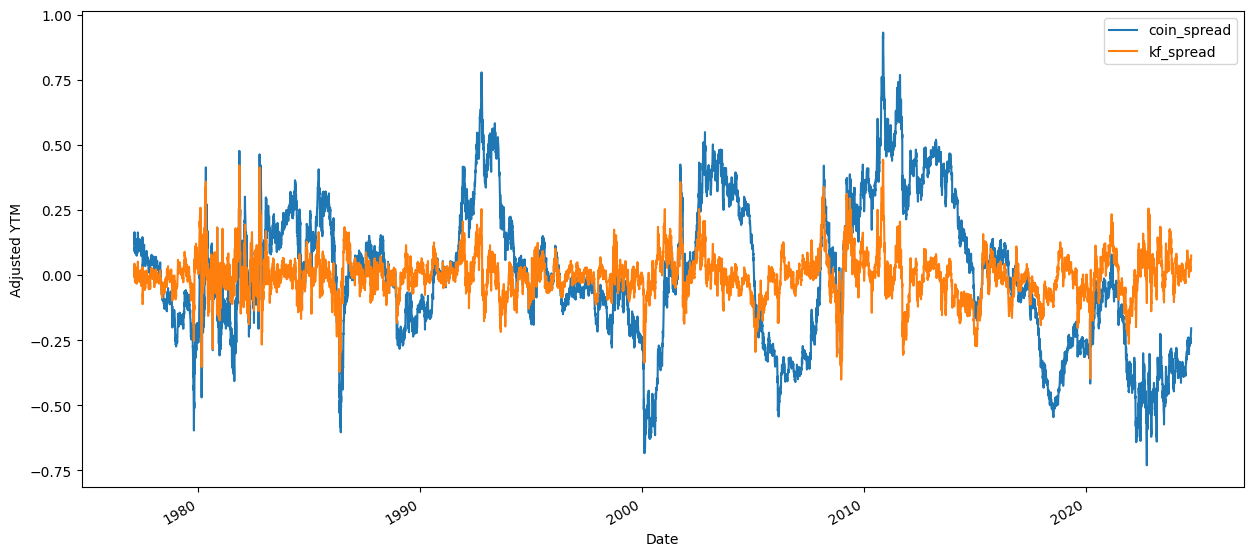

Successfully Plot YTM


In [102]:
res['coin_spread'], res['kf_spread'] = coin_spread, kf_spread
spread_syms = ["coin_spread", "kf_spread"]
visualize(res, spread_syms)

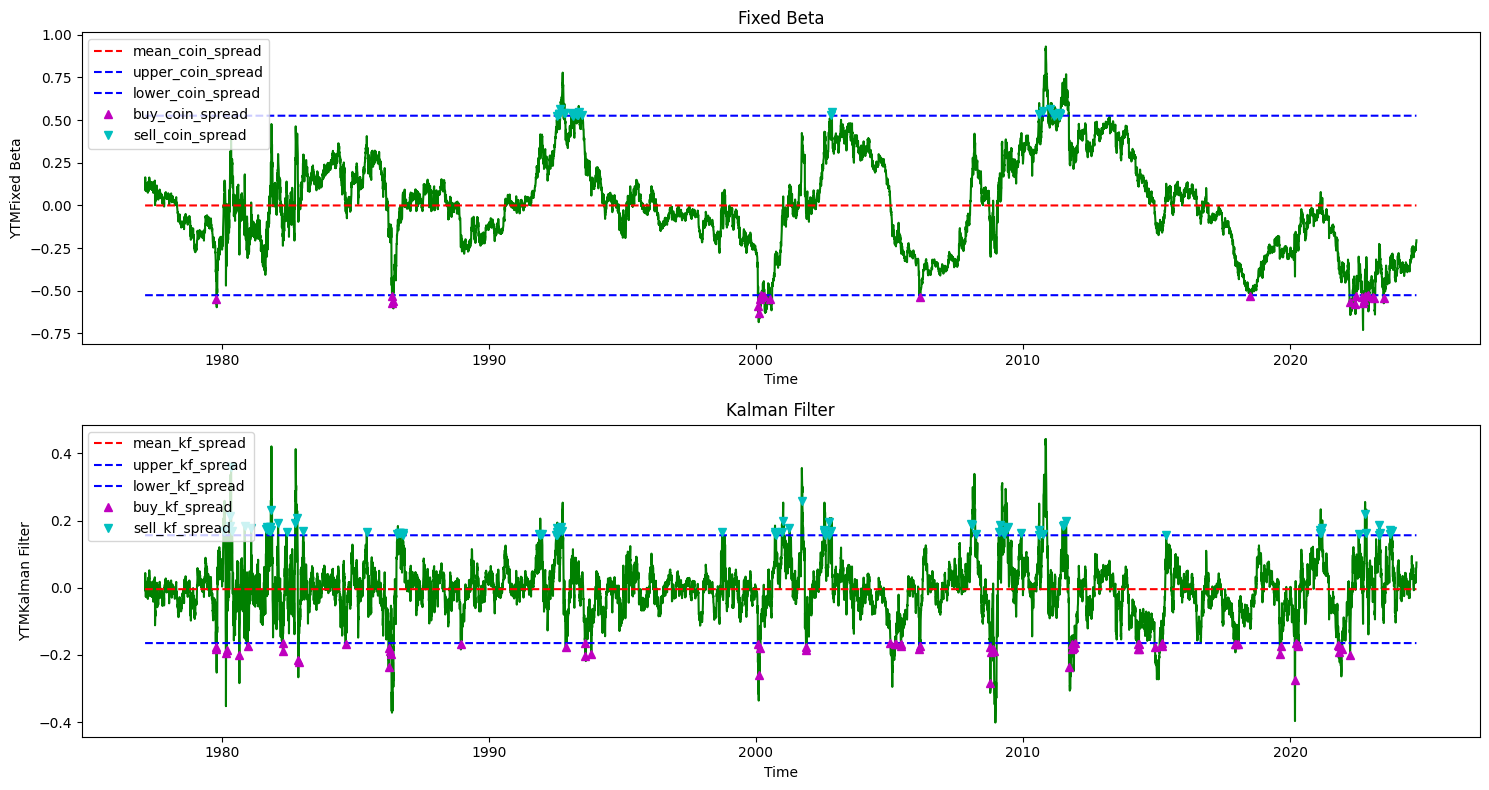

Success!


In [112]:
set_signal(res, threshold, spread_syms)